In [1]:
import torch
from torch_geometric.data import Data

import pandas             as pd
import numpy              as np
import pylab              as pl

In [2]:
params = {'legend.fontsize': '20',
          'figure.figsize': (10, 10),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
pl.rcParams.update(params)

## Reading TCW

In [3]:
data = np.loadtxt("../../data/TracingTheCosmicWeb_PublicData/fof_catalog_200Mpc512.txt", skiprows=3)
N_real = len(data)
pos = data[:N_real,[1,2,3]]
idx = np.arange(0,N_real)

In [4]:
df = pd.read_pickle('./data/TCW_dataset.pkl')
df

,connections,lambda1,lambda2,lambda3,environment,odensity
0,"[0, 2324, 2928, 4068, 4241, 6266, 7123, 7518, ...",0.115914,0.17722,0.417372,0,27.422717
1,"[1, 161, 1054, 1082, 1387, 1541, 1928, 2525, 2...",0.110396,0.366586,0.52877,0,27.422717
2,"[2, 277, 1447, 1676, 3095, 3372, 4635, 4697, 9...",0.016413,0.180315,0.393326,0,27.422717
3,"[3, 71, 890, 1213, 1628, 1755, 3174, 3606, 456...",0.093064,0.284996,0.404295,0,27.422717
4,"[4, 32, 1158, 1308, 2562, 3532, 3894, 4304, 44...",0.195352,0.257187,0.286127,0,27.422717
...,...,...,...,...,...,...
281460,"[476, 686, 1231, 2994, 4319, 5983, 6941, 8413,...",-0.109727,0.071039,0.214417,1,27.422717
281461,"[476, 686, 1231, 2994, 4319, 5983, 6941, 8413,...",-0.108436,0.066158,0.211369,1,27.422717
281462,"[476, 686, 1231, 4319, 5983, 6941, 8413, 9724,...",-0.113513,0.06743,0.205708,1,55.845434
281463,"[476, 6941, 8413, 9724, 13029, 15635, 18410, 1...",-0.120994,0.058269,0.188708,1,27.422717


# Regression Task

In [5]:
A = np.concatenate([ np.zeros(len(c[1:]))+i for i, c in  enumerate(df['connections']) ]).ravel()

In [6]:
B = np.concatenate([ c[1:] for i, c in  enumerate(df['connections']) ]).ravel()

In [7]:
len(A), len(B)

(32670030, 32670030)

In [8]:
edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions

/tmp/ipykernel_140214/3379307804.py:1: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions


In [9]:
edge_index

tensor([[     0,      0,      0,  ..., 281464, 281464, 281464],
        [  2324,   2928,   4068,  ..., 280572, 280576, 281464]])

In [10]:
predictors = np.array(df[['lambda1','lambda2','lambda3']], dtype=float)
np.shape(predictors)

(281465, 3)

In [11]:
x = torch.tensor(predictors, dtype=torch.float)  #features

In [12]:
target = np.array([ c for c in  df['odensity'] ])
np.shape(target)

(281465,)

In [13]:
y = torch.tensor(target, dtype=torch.float)  #target

In [14]:
ii_train = idx <=len(idx)*0.7
train_mask = ii_train
test_mask  = ~ii_train
sum(train_mask), sum(test_mask)

(197026, 84439)

In [15]:
data = Data(x=x, edge_index=edge_index, y=y)

In [16]:
data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

In [17]:
data

Data(edge_index=[2, 32670030], test_mask=[281465], train_mask=[281465], x=[281465, 3], y=[281465])

In [18]:
data.num_nodes

281465

In [19]:
data.num_edges

32670030

In [20]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 32)
        self.linear1 = torch.nn.Linear(32, 1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        
        return x

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device='cpu'
model = GCNR().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()

cuda


/tmp/ipykernel_140214/782510735.py:12: UserWarning: Using a target size (torch.Size([197026])) that is different to the input size (torch.Size([197026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].float())


RuntimeError: CUDA out of memory. Tried to allocate 144.61 GiB (GPU 0; 39.59 GiB total capacity; 1.78 GiB already allocated; 32.58 GiB free; 3.46 GiB reserved in total by PyTorch)

/tmp/ipykernel_140214/398370075.py:3: UserWarning: Using a target size (torch.Size([84439])) that is different to the input size (torch.Size([84439, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(pred[data.test_mask], data.y[data.test_mask].float()))


tensor(1287.1862, device='cuda:0', grad_fn=<MseLossBackward>)


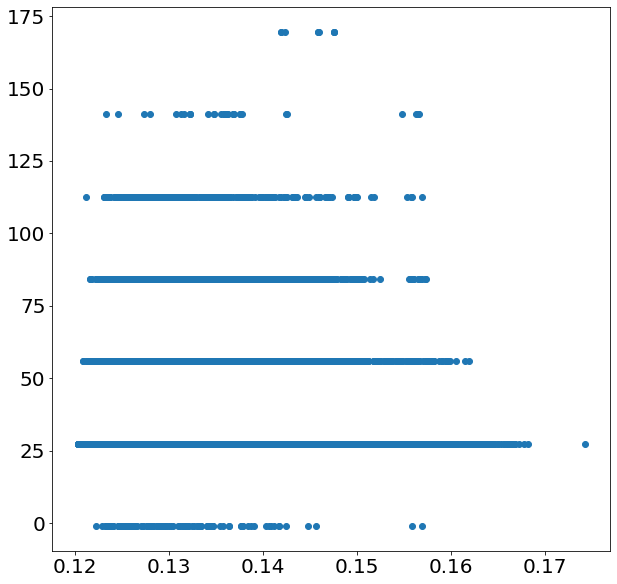

In [22]:
model.eval()
pred = model(data)
print(F.mse_loss(pred[data.test_mask], data.y[data.test_mask].float()))
pl.scatter(pred[data.test_mask].tolist(), data.y[data.test_mask].float().tolist())